# Polynomial Regression using Coordinate Descent, Least Squares, and LASSO

This workbook was actually created after I completed the assignments for LASSO in the Coursera Machine Learning Specialization Regression course, Week 5.  This workbook is to reinforce some of the learning and also to dive deeper into some of the details that lacked depth during the assignments.

Much like the other workbooks I've created up to this point, the point of this workbook is to create a line and add fake noise, then solve for the true line using coordinate descent while applying LASSO. 

## Part 1:  Setup

In [3]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Solve For Coefficients Using Coordinate Descent & Least Squares

First we need to create some functions.  The first one we need is a function to compute predictions given a feature matrix and coefficients.

In [4]:
def predict_outcome(feature_matrix, weights):
    predictions = np.dot(feature_matrix, weights)
    return(predictions)

Next we need a function to normalize our features.  We'll be using **numpy.linalg.norm** here, so let's learn a bit about how numpy.linalg.norm works.  To do this, lets break down the inputs:
 - x = input array .. seems pretty straight forward
 - ord = Order of the norm .. this seems to be where the real meat and potatoes are so lets dive deeper here
 
 According to the numpy doc there are roughly 11 acceptable values for ord broken down into a table as such.
 
| ord   | norm for matrices         | norm for vectors         |
|-------|---------------------------|--------------------------|
| None  | Frobenius norm            | 2-norm                   |
|‘fro’  |	Frobenius norm	        | -                        |
|‘nuc’	| nuclear norm	            | –                        |
| inf	| max(sum(abs(x), axis=1))	|max(abs(x))               |
|-inf	| min(sum(abs(x), axis=1))	| min(abs(x))              |
| 0	    | –	                        |sum(x != 0)               |
| 1	    | max(sum(abs(x), axis=0))	| as below                 |
| -1	| min(sum(abs(x), axis=0))	| as below                 |
| 2	    | 2-norm (largest sing. val)| as below                 |
| -2	| smallest singular value	| as below                 |
| other	| –	                        |sum(abs(x)**ord)**(1./ord)|           

With this in mind, lets look at the other inputs.
- axis = If axis is an integer, it specifies the axis of x along which to compute the vector norms. If axis is a 2-tuple, it specifies the axes that hold 2-D matrices, and the matrix norms of these matrices are computed. If axis is None then either a vector norm (when x is 1-D) or a matrix norm (when x is 2-D) is returned.
- keepdims = If this is set to True, the axes which are normed over are left in the result as dimensions with size one. With this option the result will broadcast correctly against the original x.

The default values are x, ord=None, axis=None, keepdims=False

So we'll be computing the 2-norm for each column.

First lets test our the function so we know exactly what it's doing.  We'll first run the numpy function on a numpy array, and then we'll see if we can match the result by computing the 2-norm without the numpy function.

The 2-norm function is as follows.

$$\sqrt{\sum_{i=1}^n x_i^2}$$

Lets try this out.
 

In [5]:
mylist = np.array([1,2,3,4,5,6,7,8,9])
result1 = np.linalg.norm(mylist)
two_norm = np.sqrt(np.sum(mylist**2))
print(result1)
print(two_norm)

16.8819430161
16.8819430161


We can normalize our data by taking our data and dividing each value by the 2-norm.  

If we try to normalize this data using the 2-norm, what does it look like?

In [6]:
normalized_data = mylist / two_norm
print(normalized_data)

[ 0.05923489  0.11846978  0.17770466  0.23693955  0.29617444  0.35540933
  0.41464421  0.4738791   0.53311399]


Notice that all values are now between 0 and 1.

Now if we look at the 2-norm for our normalized data, we should get 1.

In [7]:
np.sqrt(np.sum((normalized_data)**2))

0.99999999999999989

Here are some references for what we just covered:
<br>https://www.utdallas.edu/~herve/abdi-Normalizing2010-pretty.pdf
<br>https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.norm.html
<br>http://www.math.usm.edu/math/lambers/mat610/sum10/lecture2.pdf

Now that we know more about normalizing and numpy.linalg.norm, lets create a function for normalizing our data using 2-norm

In [8]:
def normalize_data(data):
    two_norms = np.linalg.norm(data, axis=0)
    normalized_data = data / two_norms
    return (normalized_data)

Now that we have our functions for normalizing data and calculating predictions, lets move on to our coordinate descent algorithm with LASSO.  From the Coursera course, remember the algoritm is as follows:

<img src="https://github.com/yeamusic21/Coursera-Machine-Learning-Specialization-Extra-Assignments/blob/master/Regression/img/lasso_algorithm.PNG?raw=true">

Lets get some better understanding for the rho_j function that's given in class.  Lets create some quick fake data, normalize it, then do a quick calculation of rho_j using the formula from class...


#### Create some data

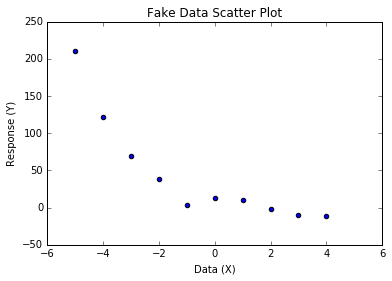

In [9]:
# simulate some data
column1 = np.repeat(1, 10)
column2 = np.arange(-5,5,1)
column3 = column2**2
column4 = column2**3
X = np.array([column1,column2,column3,column4])
X = X.transpose()

B = np.array([-2,1,3,-1])
B = B.transpose()
# create some fake noise
e = np.array(np.random.normal(0, 10.564, 10))
e = e.transpose()
# finally, create fake response data
Y = np.add(np.dot(X,B), e)

# plot our fake data to make sure it looks as we would expect (linear relationship with noise)
plt.scatter(X[:,1], Y)
plt.title('Fake Data Scatter Plot')
plt.xlabel("Data (X)")
plt.ylabel("Response (Y)")
plt.show()

#### Normalize it

In [10]:
X_norm = normalize_data(X)

In [11]:
print(X_norm)

[[ 0.31622777 -0.54232614  0.68473879 -0.78424257]
 [ 0.31622777 -0.43386092  0.43823283 -0.4015322 ]
 [ 0.31622777 -0.32539569  0.24650597 -0.1693964 ]
 [ 0.31622777 -0.21693046  0.10955821 -0.05019152]
 [ 0.31622777 -0.10846523  0.02738955 -0.00627394]
 [ 0.31622777  0.          0.          0.        ]
 [ 0.31622777  0.10846523  0.02738955  0.00627394]
 [ 0.31622777  0.21693046  0.10955821  0.05019152]
 [ 0.31622777  0.32539569  0.24650597  0.1693964 ]
 [ 0.31622777  0.43386092  0.43823283  0.4015322 ]]


#### quick computation of rho_j

In [12]:
initial_weights = [1,1,1,1]
prediction = predict_outcome(X_norm, weights=initial_weights)
j = 3

ro_j = np.sum(X_norm[:,j]*(Y - prediction + initial_weights[j]*X_norm[:,j]))
print(ro_j)

-234.194715911


Lets try computing this in a differnt way, and see if we get the same answer

In [13]:
prediction = predict_outcome(X_norm[:,0:2], weights=initial_weights[0:2])
ro_j_new = np.sum(X_norm[:,j]*(Y - prediction))
print(ro_j_new)

-234.731717224


let's try another one

In [14]:
initial_weights = [1,1,1,1]
prediction = predict_outcome(X_norm, weights=initial_weights)
j = 0

ro_j = np.sum(X_norm[:,j]*(Y - prediction + initial_weights[j]*X_norm[:,j]))
print(ro_j)

139.831842641


In [15]:
Y - prediction + initial_weights[j]*X_norm[:,j]

array([ 211.08146225,  122.7554228 ,   68.96413043,   38.90733968,
          3.05874503,   12.6610932 ,   10.5161682 ,   -2.63841781,
        -10.29697182,  -12.82185979])

In [16]:
prediction = predict_outcome(X_norm[:,1:3], weights=initial_weights[1:3])
ro_j_new = np.sum(X_norm[:,j]*(Y - prediction))
print(ro_j_new)

139.583843365


In [17]:
Y - prediction

array([ 210.29721968,  122.35389061,   68.79473404,   38.85714816,
          3.05247109,   12.6610932 ,   10.52244214,   -2.58822629,
        -10.12757543,  -12.4203276 ])

So we can see that both methods are essentially the same, but we're going to use the 1st method because it's easier to implement.  

In the 1st method we compute the prediction using all the data, but then we want to calculate the residual using a prediction that excludes the variable of interest.  So what do we do?  We simply calcuate the residual with the full model, then add back in the effect of the variable (j) of interest.  

In the 2nd method we simply calculate the prediction without the variable of interest (j), and then use those predictions in our residual calculation.

It's essentially the same thing with some minor error, but we'll use the 1st method because it will be easier to code (even though it might seem less intuitive, but hopefully this explanation helped).

Now that we understand our Rho calculation and our algorithm, let's push on.  First we'll define a function for 1 step of descent, then we'll define the full algorithm.

In [18]:
def lasso_coordinate_descent_step(i, feature_matrix, output, weights, l1_penalty):
    # compute prediction
    prediction = predict_outcome(feature_matrix, weights)
    # compute ro[i] = SUM[ [feature_i]*(output - prediction + weight[i]*[feature_i]) ]
    ro_i = np.sum(feature_matrix[:,i]*(output - prediction + weights[i]*feature_matrix[:,i]))
    
    if i == 0: # intercept -- do not regularize
        new_weight_i = ro_i
    elif ro_i < -l1_penalty/2.:
        new_weight_i = ro_i + l1_penalty/2
    elif ro_i > l1_penalty/2.:
        new_weight_i = ro_i - l1_penalty/2
    else:
        new_weight_i = 0.
    
    return new_weight_i

In [19]:
def lasso_cyclical_coordinate_descent(feature_matrix, output, initial_weights, l1_penalty, tolerance):
    tot_change = tolerance + 1
    weights = initial_weights
    diffs = np.zeros(len(initial_weights))
    while tot_change > tolerance:
        for i in range(len(initial_weights)):
            last_w_i = weights[i]
            weights[i] = lasso_coordinate_descent_step(i, feature_matrix, output, weights, l1_penalty)
            diffs[i] = abs(last_w_i - weights[i])
        tot_change = np.sum(diffs)
    return weights

## Part 2:  Implementation

### Let's create some new fake data to play with

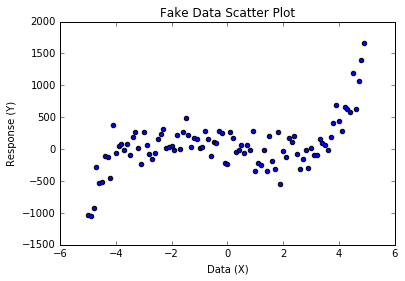

In [20]:
#### CREATE FAKE DATA

# imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# simulate some data
column1 = np.repeat(1, 100)
column2 = np.arange(-5,5,.1)
column3 = column2**2
column4 = column2**3
column5 = column2**4
column6 = column2**5
X = np.array([column1,column2,column3,column4,column5,column6])
X = X.transpose()
# make up some parameters
B = np.array(np.array([0.345,-90.961,-1.109,0.432,0.657,0.548]))
B = B.transpose()
# create some fake noise
e = np.array(np.random.normal(0, 200, 100))
e = e.transpose()
# finally, create fake response data
Y = np.add(np.dot(X,B), e)

# plot our fake data to make sure it looks as we would expect (linear relationship with noise)
plt.scatter(X[:,1], Y)
plt.title('Fake Data Scatter Plot')
plt.xlabel("Data (X)")
plt.ylabel("Response (Y)")
plt.show()

#### Need to remember to normalize our data first

In [21]:
X_norm = normalize_data(X)

##### Lets start with a small penalty

    Features    Estimates
0  intercept   344.976910
1         X1 -1551.942846
2         X2  -628.427056
3         X3 -1511.315352
4         X4  1632.244924
5         X5  6078.405973


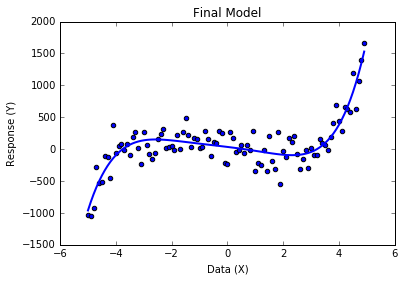

In [25]:
# fit model
model_final_coefs = lasso_cyclical_coordinate_descent(feature_matrix=X_norm, 
                                                      output=Y, 
                                                      initial_weights=np.repeat(1e-5,6), 
                                                      l1_penalty=1, 
                                                      tolerance=1)

# print model summary
model_summary = pd.DataFrame(zip(['intercept','X1','X2','X3','X4','X5'],model_final_coefs), 
                             columns=['Features','Estimates'])

print(model_summary)

# plot data and final model
predictions = predict_outcome(X_norm, weights=model_final_coefs)
plt.scatter(X[:,1], Y)
plt.plot(X[:,1], predictions, linewidth=2.0)
plt.title('Final Model')
plt.xlabel("Data (X)")
plt.ylabel("Response (Y)")
plt.show()

##### Now lets try a larger penalty

    Features    Estimates
0  intercept   700.032706
1         X1     0.000000
2         X2     0.000000
3         X3     0.000000
4         X4   187.004403
5         X5  2747.038672


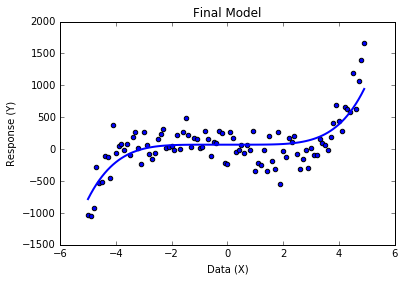

In [26]:
# fit model
model_final_coefs = lasso_cyclical_coordinate_descent(feature_matrix=X_norm, 
                                                      output=Y, 
                                                      initial_weights=np.repeat(1e-5,6), 
                                                      l1_penalty=1000, 
                                                      tolerance=1)

# print model summary
model_summary = pd.DataFrame(zip(['intercept','X1','X2','X3','X4','X5'],model_final_coefs), 
                             columns=['Features','Estimates'])

print(model_summary)

# plot data and final model
predictions = predict_outcome(X_norm, weights=model_final_coefs)
plt.scatter(X[:,1], Y)
plt.plot(X[:,1], predictions, linewidth=2.0)
plt.title('Final Model')
plt.xlabel("Data (X)")
plt.ylabel("Response (Y)")
plt.show()

#### What if we didn't normalize first?

In [24]:
# fit model
model_final_coefs = lasso_cyclical_coordinate_descent(feature_matrix=X, 
                                                      output=Y, 
                                                      initial_weights=np.repeat(1e-5,6), 
                                                      l1_penalty=1000, 
                                                      tolerance=1)

# print model summary
pd.DataFrame(zip(['intercept','X1','X2','X3','X4','X5'],model_final_coefs), columns=['Features','Estimates'])

,Features,Estimates
0,intercept,NaN
1,X1,0.0
2,X2,0.0
3,X3,0.0
4,X4,0.0
5,X5,0.0


The takeaway here should be that normalizing is pretty important for LASSO.